In [6]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [2]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


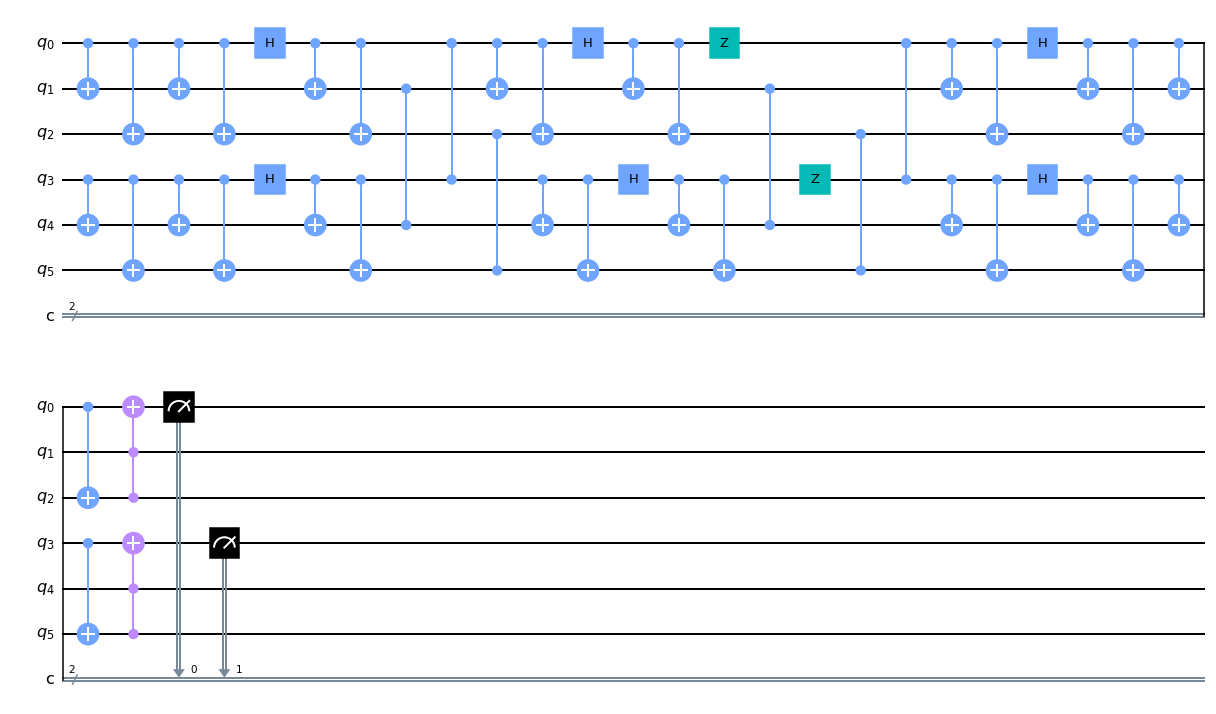

In [12]:
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

# encode
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[5])

# hadamard
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.h(qreg_q[0])
circuit.h(qreg_q[3])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[5])

# controlled z
circuit.cz(qreg_q[0], qreg_q[3])
circuit.cz(qreg_q[1], qreg_q[4])
circuit.cz(qreg_q[2], qreg_q[5])

# Hadamard
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[3])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[3], qreg_q[5])

# z gate
circuit.z(qreg_q[0])
circuit.z(qreg_q[3])

# controlled z
circuit.cz(qreg_q[0], qreg_q[3])
circuit.cz(qreg_q[1], qreg_q[4])
circuit.cz(qreg_q[2], qreg_q[5])

# Hadamard
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[3])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[1])

circuit.cx(qreg_q[3], qreg_q[5])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[4])
circuit.ccx(qreg_q[2], qreg_q[1], qreg_q[0])
circuit.cx(qreg_q[3], qreg_q[5])
circuit.ccx(qreg_q[5], qreg_q[4], qreg_q[3])
circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[3], creg_c[1])

circuit.draw(output='mpl')

In [3]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'u3', 'u2', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


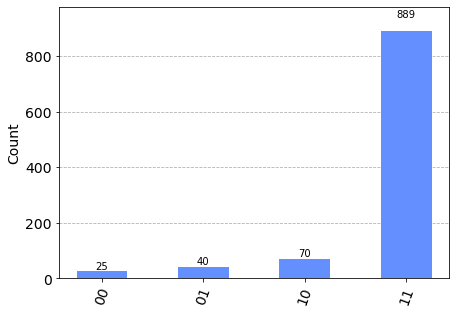

In [8]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circuit, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

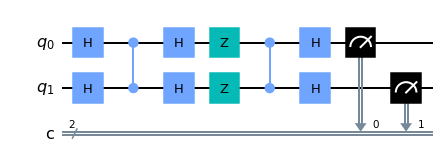

In [13]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
g_circuit = QuantumCircuit(qreg_q, creg_c)

g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.cz(qreg_q[0], qreg_q[1])
g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.z(qreg_q[0])
g_circuit.z(qreg_q[1])
g_circuit.cz(qreg_q[0], qreg_q[1])
g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.measure(qreg_q[0], creg_c[0])
g_circuit.measure(qreg_q[1], creg_c[1])

g_circuit.draw(output='mpl')

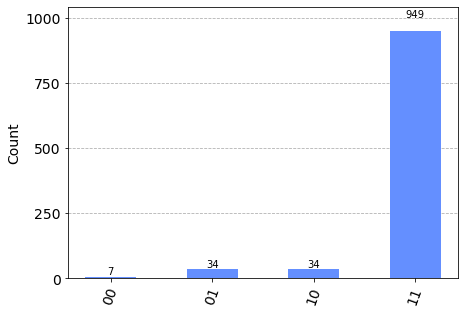

In [11]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(g_circuit, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)